The spatial-temporal overlapping data of fish and water were selected to construct MSEM model  
鱼类和水时空重叠数据 筛选变量用于后续构建MSEM模型

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import myrfecv as mr

path_data_raw = "C:/Users/dell/OneDrive/file/"
path_country_nc = "C:/Users/dell/OneDrive/file/nc"
path_onedrive_csv = "C:/Users/dell/OneDrive/file/csv/"
path_one_spdb = 'C:/Users/dell/OneDrive/file/SPDB/'
drive_letter = 'E:'

path_pre = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/part0_treat/pretreatment/"
path_match = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/part0_treat/match/"
path_semdata = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/part0_treat/semdata/"

path_2_preanalysis_data = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/part2_sem/preanalysis/"
path_2_preanalysis_fig = drive_letter + "/wyy/code_project/running_outcome/final_fig/SPDB/part2_sem/preanalysis/"
path_3_sw_forecast = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/part3_forecast/sw_forecast/"
path_temp = drive_letter + "/wyy/code_project/running_outcome/final_data/SPDB/temp/"


mark_num = "25"
meta_name = "meta_data.csv"
list_pfas =['PFOA', 'PFNA', 'PFDA', 'PFUnDA','PFDoDA','PFTrDA', 'PFTeDA', 'PFHxS', 'PFOS', 'FOSA', 'PFBA', 'PFPeA', 'PFHxA', 'PFHpA','PFBS']
list_pfas_lc = ['PFOA', 'PFNA', 'PFDA', 'PFUnDA','PFDoDA','PFTrDA', 'PFTeDA', 'PFHxS', 'PFOS', 'FOSA']
list_pfas_sc = ['PFBA', 'PFPeA', 'PFHxA', 'PFHpA','PFBS']
list_color = ["#4d8cbf", "#4f9c8b", "#555c6c", "#d77563", "#7d84a8", "#84aeb8", "#c3473b", "#89756d","#ffb3cc","#9a7ebf","#ffddb8", "#c4eaff", "#d1c6ff", "#c2ffbf", "#f5f5b0"]
dic_color = dict(zip(list_pfas,list_color))

In [2]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
def start_rfecv(key, clf, df, str_describe, path_data, path_fig, mark_num=''):
    df_rfecv = df.copy()
    min_features_to_select = 20
    X = df_rfecv.drop('value', axis=1)
    y = df_rfecv['value']
    scoring = 'r2'
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=202406)
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring=scoring,
        min_features_to_select=min_features_to_select,
        n_jobs=8,
    )
    rfecv.fit(X, y)
    
    print(f"{key} Optimal number of features: {rfecv.n_features_}")

    selected_features = X.columns[rfecv.support_]
    feature_importances = pd.Series(rfecv.estimator_.feature_importances_, index=selected_features)
    all_features_ranking = pd.Series(rfecv.ranking_, index=X.columns)

    feature_selection_info = pd.DataFrame({
        'Feature': X.columns,
        'Selected': rfecv.support_,
        'Rank': rfecv.ranking_,
    })
    
    if hasattr(rfecv.estimator_, 'feature_importances_'):
        feature_selection_info['Importance'] = feature_selection_info.apply(
            lambda row: feature_importances[row['Feature']] if row['Selected'] else 0, axis=1)
    
    feature_selection_info = feature_selection_info.sort_values(by='Importance', ascending=False)

    # Save feature selection info
    feature_selection_info.to_csv(path_data + str_describe + "_rfecv_features_" + key + mark_num+".csv", index=False)

    # Plot the results
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean R2")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.savefig(path_fig + str_describe + "_rfecv_" + scoring +"_"+ key + mark_num+".png", dpi=300)

    # Save data for the plot
    df_plot = pd.DataFrame({
        'min_features': range(min_features_to_select, n_scores + min_features_to_select),
        'mean_test_score': rfecv.cv_results_["mean_test_score"],
        'std_test_score': rfecv.cv_results_["std_test_score"]
    })
    df_plot = df_plot.sort_values(by='mean_test_score', ascending=False)
    df_plot.to_csv(path_data + str_describe + "_rfecv_" + scoring +"_" + key + mark_num+".csv", index=False)
    
    return "okk"

GBDT Optimal number of features: 50
RF Optimal number of features: 51


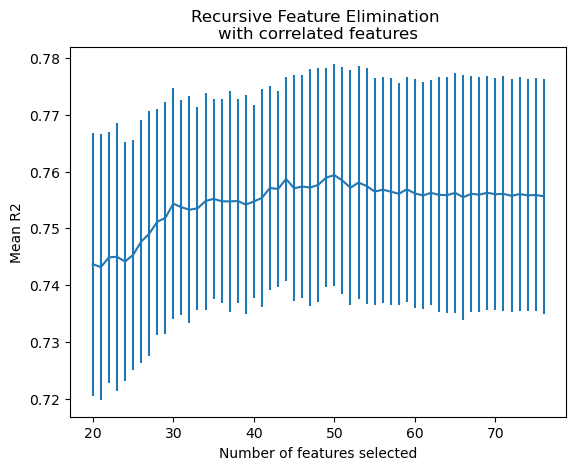

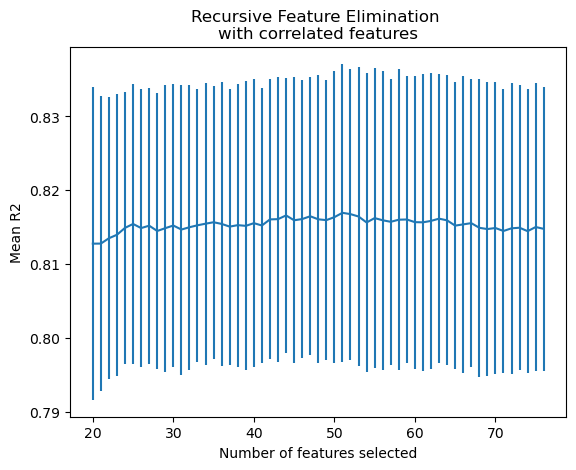

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
dict_clf = {
    'GBDT': GradientBoostingRegressor(random_state=202406),
    'RF': RandomForestRegressor(random_state=202406),
}
str_prefix = 'lr_sws7'

df_lrsw_data = pd.read_csv(path_semdata + "sem_"+str_prefix+"_au_to_25_avg.csv")
path_lrsw_rfecv_data = drive_letter + '/wyy/code_project/running_outcome/final_data/SPDB/part3_forecast/lrsw_forecast/'
path_lrsw_rfecv_fig = drive_letter + '/wyy/code_project/running_outcome/final_fig/SPDB/part3_forecast/lrsw_forecast/'
df_lrsw_data['year'] = (df_lrsw_data['year'] - 2000) / (2020 - 2000)

columns_to_drop = ['lon_grid', 'lat_grid']
df_lrsw_data = df_lrsw_data.drop(columns=columns_to_drop)

for key, clf in dict_clf.items():
    start_rfecv(key, clf, df_lrsw_data, str_prefix, path_lrsw_rfecv_data, path_lrsw_rfecv_fig, 'cv')

In [4]:
df_lrsw_rf_rfecv = pd.read_csv(path_lrsw_rfecv_data + str_prefix + '_rfecv_r2_RFcv.csv')
df_lrsw_rf_rfecv['model'] = 'RF'
df_lrsw_gbdt_rfecv = pd.read_csv(path_lrsw_rfecv_data + str_prefix + '_rfecv_r2_GBDTcv.csv')
df_lrsw_gbdt_rfecv['model'] = 'GBDT'

df_lrsw_rfecv = pd.concat([df_lrsw_rf_rfecv,df_lrsw_gbdt_rfecv],axis=0)

df_lrsw_rfecv = df_lrsw_rfecv.sort_values(by='mean_test_score', ascending=False)

max_index = df_lrsw_rfecv['mean_test_score'].idxmax()
min_features = df_lrsw_rfecv.loc[max_index, 'min_features'].tolist()[0]
max_model = df_lrsw_rfecv.loc[max_index, 'model'].tolist()[0]
max_score = round(df_lrsw_rfecv.loc[max_index, 'mean_test_score'].tolist()[0],3)
df_lrsw_rfecv.to_csv(path_lrsw_rfecv_data + str_prefix +'_merge_rfecv.csv',index=False)
print(f'model:{max_model} min_feature:{min_features} score:{max_score}')


model:RF min_feature:51 score:0.817
